In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [107]:
wildfires = pd.read_csv("wildfires.csv")  

In [108]:
columns_to_drop = [
    'State', 'Alarm Date', 'Containment Date', 'Complex Name', 'Fire Number (historical use)',
    'Agency', 'Fire ID', 'Unit ID', 'Fire Name', 'Local Incident Number', 'Date',
    'Comments', 'IRWIN ID', 'Complex ID'
]
wildfires.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [109]:
# Map numeric causes to categorical labels
cause_mapping = {
    1: 'Lightning', 2: 'Equipment Use', 3: 'Smoking', 4: 'Campfire', 5: 'Debris',
    6: 'Railroad', 7: 'Arson', 8: 'Playing with fire', 9: 'Miscellaneous', 10: 'Vehicle Accident',
    11: 'Powerline', 12: 'Firefighter Training', 13: 'Non-Firefighter Training',
    14: 'Unknown/Unidentified', 15: 'Structure', 16: 'Aircraft', 17: 'Volcanic',
    18: 'Escaped Prescribed Burn', 19: 'Illegal Alien Campfire'
}
wildfires['Cause'] = wildfires['Cause'].map(cause_mapping)

In [110]:
# Human and Nature Sorting
human_causes = [
    'Smoking', 'Campfire', 'Equipment Use', 'Playing with fire', 'Arson', 'Railroad',
    'Vehicle', 'Powerline', 'Firefighter Training', 'Non-Firefighter Training',
    'Structure', 'Aircraft', 'Escaped Prescribed Burn', 'Illegal Alien Campfire'
]
nature_causes = ['Lightning', 'Volcanic', 'Debris']
wildfires['Cause_Category'] = wildfires['Cause'].apply(lambda x: 'Human' if x in human_causes else 'Nature' if x in nature_causes else np.nan)

In [111]:
# Convert 'Year' to integer and filter data for the last 6 years (2018-2023)
wildfires['Year'] = pd.to_numeric(wildfires['Year'], errors='coerce')
wildfires = wildfires[wildfires['Year'].between(2018, 2023)]

# Remove rows with missing values in critical columns (optional)
wildfires.dropna(subset=['GIS Calculated Acres', 'Cause_Category'], inplace=True)

In [112]:
# One-hot encoding for 'Cause' and 'Cause_Category' columns
wildfires_encoded = pd.get_dummies(wildfires, columns=['Cause', 'Cause_Category'], drop_first=True)

In [113]:
# Dependent Variable: binarizing fire size based on a threshold
threshold = wildfires['GIS Calculated Acres'].mean()  # Set a threshold to classify fires into 'large' or 'small'
wildfires['Fire_Size_Category'] = wildfires['GIS Calculated Acres'].apply(lambda x: 1 if x > threshold else 0) 

In [115]:
conditions = [
    wildfires['GIS Calculated Acres'] < threshold / 2,
    (wildfires['GIS Calculated Acres'] >= threshold / 2) & (wildfires['GIS Calculated Acres'] <= threshold * 1.5),
    wildfires['GIS Calculated Acres'] > threshold
]
categories = [0,1,2] 

wildfires['Fire_Size_Category'] = np.select(conditions, categories, default=-1) 

In [116]:
# Feature Selection: using the one-hot encoded 'Cause' and other features as independent variables
X = wildfires_encoded.drop(['GIS Calculated Acres', 'Fire_Size_Category'], axis=1, errors='ignore')
y = wildfires['Fire_Size_Category'] 

In [122]:
X.columns 

Index(['OBJECTID', 'Year', 'Collection Method', 'Management Objective',
       'DECADES', 'Shape__Area', 'Shape__Length', 'Cause_Arson',
       'Cause_Campfire', 'Cause_Debris', 'Cause_Equipment Use',
       'Cause_Escaped Prescribed Burn', 'Cause_Lightning',
       'Cause_Playing with fire', 'Cause_Powerline', 'Cause_Railroad',
       'Cause_Smoking', 'Cause_Structure', 'Cause_Category_Nature'],
      dtype='object')

In [123]:
#start of implementing the model

In [136]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 

In [137]:
# KNN Model (Dropping NaN values) 
X_train_logistic = X_train.dropna()
y_train_logistic = y_train[X_train_logistic.index]  # Ensure y is aligned with the reduced X after dropping NaN rows
X_test_logistic = X_test.dropna()
y_test_logistic = y_test[X_test_logistic.index] 

In [138]:
k = 7  # You can change this value
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn_classifier.fit(X_train_logistic, y_train_logistic)

# Make predictions
y_pred = knn_classifier.predict(X_test_logistic)

# Evaluate the model
accuracy = accuracy_score(y_test_logistic, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.99


In [139]:
# # Initialize and train the logistic regression model
# knn_model = LogisticRegression(max_iter=1000)
# knn_model.fit(X_train_logistic, y_train_logistic) 

In [141]:
print("Training set class distribution:", y_train_logistic.value_counts())
print("Test set class distribution:", y_test_logistic.value_counts())

Training set class distribution: Fire_Size_Category
0    544
2     28
1     13
Name: count, dtype: int64
Test set class distribution: Fire_Size_Category
0    365
2     13
1     12
Name: count, dtype: int64


In [142]:
#using other methods of evalutation because accuracy isn't going to be that accurate due to imbalanced data
from sklearn.metrics import classification_report

print(classification_report(y_test_logistic, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       0.92      0.92      0.92        12
           2       1.00      0.92      0.96        13

    accuracy                           0.99       390
   macro avg       0.97      0.95      0.96       390
weighted avg       0.99      0.99      0.99       390



In [146]:
# Drop NaNs in the full dataset
X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index]  # Align y with the cleaned X 

#further checking the effeciency of the model using cross val
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn_classifier, X_cleaned, y_cleaned, cv=5, scoring='f1_macro')
print("Cross-validation F1 scores:", scores)
print("Mean cross-validation F1 score:", scores.mean()) 

Cross-validation F1 scores: [1.         1.         1.         0.94747475 0.8231685 ]
Mean cross-validation F1 score: 0.9541286491286491


In [147]:
#this is good but we also want to try a range of k values to find the best one

In [148]:
k_values = range(1, 21)  # Test values of k from 1 to 20
f1_scores = []

# Loop through each k value, perform cross-validation, and store the mean F1 score
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Perform cross-validation and calculate the mean F1-macro score
    scores = cross_val_score(knn, X_cleaned, y_cleaned, cv=5, scoring='f1_macro')
    f1_scores.append(scores.mean())
    print(f"k={k}, Mean F1 Score: {scores.mean():.4f}")

k=1, Mean F1 Score: 0.9819
k=2, Mean F1 Score: 0.9819
k=3, Mean F1 Score: 0.9819
k=4, Mean F1 Score: 0.9604
k=5, Mean F1 Score: 0.9725
k=6, Mean F1 Score: 0.9436
k=7, Mean F1 Score: 0.9541
k=8, Mean F1 Score: 0.9361
k=9, Mean F1 Score: 0.9436
k=10, Mean F1 Score: 0.9048
k=11, Mean F1 Score: 0.9048
k=12, Mean F1 Score: 0.9048
k=13, Mean F1 Score: 0.9048
k=14, Mean F1 Score: 0.8943
k=15, Mean F1 Score: 0.8943
k=16, Mean F1 Score: 0.8867
k=17, Mean F1 Score: 0.8867
k=18, Mean F1 Score: 0.8793
k=19, Mean F1 Score: 0.8793
k=20, Mean F1 Score: 0.8793


In [152]:
# Find the best k with the highest mean F1 score
best_k = k_values[np.argmax(f1_scores)]
best_score = max(f1_scores) 
print(f"Best K Value: {best_k}") 
print(f"Best Score using K Value: {best_score}") 

Best K Value: 1
Best Score using K Value: 0.9819038873584329


In [153]:
#as we can see the best K value to use would be 5 

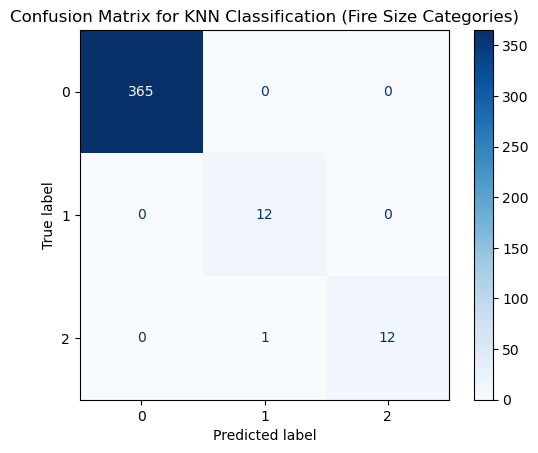

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Ensure that X_train_logistic and X_test_logistic are C-contiguous arrays
X_train_logistic = np.ascontiguousarray(X_train_logistic)
X_test_logistic = np.ascontiguousarray(X_test_logistic)

# Set the best k value
k = 1
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_logistic, y_train_logistic)

# Make predictions
y_pred = knn_classifier.predict(X_test_logistic)

# Compute and plot the confusion matrix
con_matrix = confusion_matrix(y_test_logistic, y_pred)
class_labels = [0, 1, 2]

# Plot the confusion matrix with class labels
plot = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=class_labels)
plot.plot(cmap='Blues')
plt.title("Confusion Matrix for KNN Classification (Fire Size Categories)")
plt.show() 